<h1>LSTM</h1>

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from IPython.core.interactiveshell import InteractiveShell

# LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.svm import OneClassSVM
from tensorflow.keras.layers import Dropout, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from sklearn.model_selection import ParameterSampler
from scipy.stats import skew


InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
sns.set()
pd.options.display.max_rows = 100

<h4>Importing Datasets</h4>

In [36]:
# Import dataset and clean, ready as a dataframe for creating keys
def createDF(datasets):
    df = pd.read_csv(datasets, converters={'PARTY_ID': str, 'COM_ID': str, 'CNTR_SIZE': str})

    # Formating to type and remove NaN values
    df['POD'] = pd.to_datetime(df['POD'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].fillna(-1).astype(int)
    df = df.dropna(subset=['ENCODED_TYPE'])
    df['RATE'] = df['RATE'].fillna(-1).astype(float)
    df = df.dropna(subset=['RATE'])
    df['ENCODED_TYPE'] = df['ENCODED_TYPE'].astype(int)
    df_clean= df.dropna().reset_index(drop=True)

    # Selecting and rearranging columns
    sel_col = ['CSL_ID', 'CNTR_ID','POD_ID','ETD_POL_D','PARTY_ID',
            'PARTY_NAME','POD','CNTR_SIZE','CNTR_TYPE','RATE']
    df_fc = df_clean[sel_col]

    # Removing years we do not want to process in our models
    df_filtered = df_fc[df_fc['POD'].dt.year != 2002]

    # Sorting the dates
    df_filtered = df_filtered.sort_values(by='POD').reset_index(drop=True)
    
    return df_filtered

In [37]:
# Create Dataframes for old and new
old_data = '.\Datasets\CR_COST_FC.csv'
df1 = createDF(old_data)
df1.head()

new_data = '.\Datasets\CR_COST_FC_new.csv'
df2 = createDF(new_data)
df2.head()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS01050600224,CTNR010050700354,ROTTERDAM,NLRTM,01008827,YANG MING (SINGAPORE) PTE. LTD.,2005-07-15,40,HC NOR,1620.0
1,ECS01050600610,CTNR010050700353,FELIXSTOWE,GBFXT,01002303,GLOBELINK FALLOW LIMITED,2005-07-15,40,GP,1800.0
2,ECS01050600041,CTNR010050700351,AUCKLAND,NZAKL,01005136,MONDIALE FREIGHT SERVICES LIMITED-AUCKLAND,2005-07-15,40,HC NOR,2170.0
3,ECS01050600163,CTNR010050700370,PASIR GUDANG,MYPGU,01002767,GLOBELINK CONTAINER LINES (JB) S/B,2005-07-15,40,HC,280.0
4,ECS01050600456,CTNR010050700450,KARACHI (KICT),PKKHI,01002783,GLOBELINK PAKISTAN (PVT) LTD,2005-07-16,40,HC,1625.0


<h4>Creating Dictionary Keys</h4>

In [38]:
def filter_dataframe(df):
    filtered_dataframes = {}

    for (port, size, ctype, party_id), group in df.groupby(['POD_ID', 'CNTR_SIZE', 'CNTR_TYPE', 'PARTY_ID']):
        group = group.reset_index(drop=True).sort_values(by='POD')
        df_id = f"Port_{port}_Size_{size}_Type_{ctype}_PartyID_{party_id}"
        filtered_dataframes[df_id] = group

    return filtered_dataframes

In [39]:
# Creating keys from data
print("Old Data keys:")
filtered_dataframe1 = filter_dataframe(df1)
df_ids1 = list(filtered_dataframe1.keys())
print(list(df_ids1))
print(len(list(df_ids1)))

print("\nNew Data keys:")
filtered_dataframe2 = filter_dataframe(df2)
df_ids2 = list(filtered_dataframe2.keys())
print(list(df_ids2))
print(len(list(df_ids2)))

Old Data keys:
['Port_(CONSTANZA)_Size_40_Type_GP_PartyID_010007816', 'Port_(CONSTANZA)_Size_40_Type_HC_PartyID_010007816', 'Port_AARHUS_Size_20_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_20_Type_GP_PartyID_0100027830', 'Port_AARHUS_Size_20_Type_GP_PartyID_010006666', 'Port_AARHUS_Size_40_Type_GP_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_01000043', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100027830', 'Port_AARHUS_Size_40_Type_HC_PartyID_0100028193', 'Port_AARHUS_Size_40_Type_HC_PartyID_010006666', 'Port_ABIDJAN_Size_20_Type_GP_PartyID_0100027878', 'Port_ABIDJAN_Size_40_Type_HC_PartyID_010021097', 'Port_ADELAIDE_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_GP_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE_Size_40_Type_HC_PartyID_01005078', 'Port_ADELAIDE_Size_40_Type_HC NOR_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_20_Type_GP_PartyID_01002775', 'Port_ADELAIDE(AU)_Size_40_Type_HC_PartyID_01002775', 'Port_ADELAIDE(AU)_Si

<h4>Getting Top 5 ports keys</h4>

In [40]:
def getTop5Ports(keybunch):
    keybunch_pouch = []
    
    # Get a dictionary with key and number of rows for each dataframe in filtered_dataframes
    key_row_counts = {key: len(keybunch[key]) for key in keybunch}

    # Sort the key_row_counts dictionary by value (number of rows) in descending order
    sorted_key_row_counts = sorted(key_row_counts.items(), key=lambda item: item[1], reverse=True)

    # Get the top 5 keys with the most rows
    top_5_keys_tuple = sorted_key_row_counts[:5]

    # Create a dictionary with the top 5 keys and their corresponding dataframes (with up to 5 rows per dataframe)
    keybunch_subset = {}

    for key, row_count in top_5_keys_tuple:
        keybunch_subset[key] = keybunch[key][:5]
        print(f"Number of rows in {key}: {row_count}")
        keybunch_pouch.append(key)
    
    # Return array of keys
    return keybunch_pouch

In [41]:
print('Old Dataset Keybunch:')
old_df = getTop5Ports(filtered_dataframe1)
print('\n')

print('New Dataset Keybunch:')
new_df = getTop5Ports(filtered_dataframe2)

Old Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1689
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1688
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1325
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1300
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1052


New Dataset Keybunch:
Number of rows in Port_BUSAN_Size_40_Type_HC_PartyID_010004286: 1712
Number of rows in Port_AUCKLAND_Size_40_Type_HC_PartyID_01005136: 1704
Number of rows in Port_MELBOURNE_Size_40_Type_HC_PartyID_01002778: 1341
Number of rows in Port_SYDNEY_Size_40_Type_HC_PartyID_01002779: 1308
Number of rows in Port_DUBAI (JEBEL ALI)_Size_40_Type_HC_PartyID_01002788: 1070


<h2>Selection of Key</h2>

In [42]:
# Global selection
sel_country = old_df[0]

# Accessing the highest count in the each keypouch, new and old.
sel_df = filtered_dataframe1[sel_country]
sel_df.head(5)
sel_df.tail(5)
sel_df.info()
print("\n")

latest_sel_df = filtered_dataframe2[sel_country]
latest_sel_df.head(5)
latest_sel_df.tail(5)
latest_sel_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1684,ECS010230100126,010000391908,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1685,ECS010230100126,010000380884,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-22,40,HC,300.0
1687,ECS010230100127,010000407833,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1686,ECS010230100127,010000390366,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0
1688,ECS010230100127,010000401385,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-02-28,40,HC,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1689 entries, 0 to 1688
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1689 non-null   object        
 1   CNTR_ID     1689 non-null   object        
 2   POD_ID      1689 non-null   object        
 3   ETD_POL_D   1689 non-null   object        
 4   PARTY_ID    1689 non-null   object        
 5   PARTY_NAME  1689 non-null   object        
 6   POD         1689 non-null   datetime64[ns]
 7   CNTR_SIZE   1689 non-null   object        
 8   CNTR_TYPE   1689 non-null   object        
 9   RATE        1689 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 145.1+ KB




,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010050800407,CTNR010050901151,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
1,ECS010050800407,CTNR010050901379,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-03,40,HC,390.0
2,ECS010050900468,CTNR010051000081,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
3,ECS010050900468,CTNR010050901461,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-07,40,HC,390.0
4,ECS010050900469,CTNR010051000434,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2005-10-14,40,HC,390.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
1708,ECS010230300113,010000512466,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1707,ECS010230300113,010000534846,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-03,40,HC,260.0
1709,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
1710,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
1711,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1712 entries, 0 to 1711
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      1712 non-null   object        
 1   CNTR_ID     1712 non-null   object        
 2   POD_ID      1712 non-null   object        
 3   ETD_POL_D   1712 non-null   object        
 4   PARTY_ID    1712 non-null   object        
 5   PARTY_NAME  1712 non-null   object        
 6   POD         1712 non-null   datetime64[ns]
 7   CNTR_SIZE   1712 non-null   object        
 8   CNTR_TYPE   1712 non-null   object        
 9   RATE        1712 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 147.1+ KB


In [43]:
# Select features
sel_feat = ['POD','RATE']
sel_feat_df = sel_df[sel_feat].copy()  # make a copy to avoid SettingWithCopyWarning

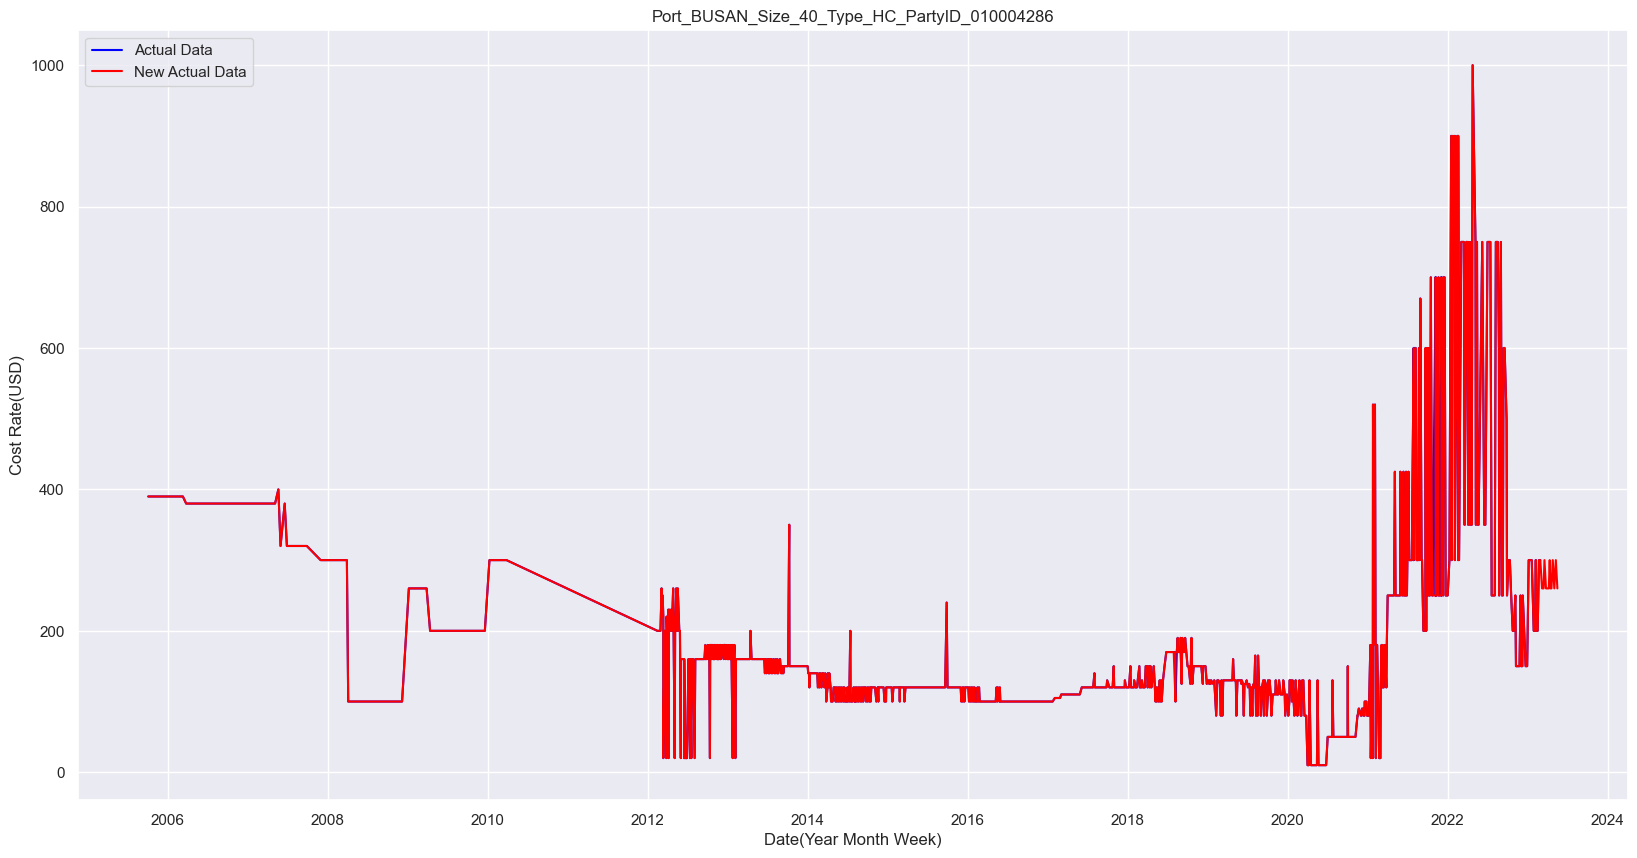

In [44]:
plt.figure(figsize=(20, 10))
plt.plot(sel_feat_df['POD'], sel_feat_df['RATE'], color='blue', label="Actual Data")
plt.plot(latest_sel_df['POD'], latest_sel_df['RATE'], color='red', label="New Actual Data")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Remove Outliers</h4>

(array([ 79.,  79., 257., 476., 246., 147.,  10., 120.,  90.,  10.,  21.,
         60.,   9.,   0.,   2.,   2.,   0.,  15.,   0.,   0.,  12.,   0.,
         46.,   0.,   0.,   0.,   7.,   0.,   0.,   1.]),
 array([  10.,   43.,   76.,  109.,  142.,  175.,  208.,  241.,  274.,
         307.,  340.,  373.,  406.,  439.,  472.,  505.,  538.,  571.,
         604.,  637.,  670.,  703.,  736.,  769.,  802.,  835.,  868.,
         901.,  934.,  967., 1000.]),
 <BarContainer object of 30 artists>)

Text(0.5, 1.0, 'Histogram of RATE')

Text(0.5, 0, 'RATE')

Text(0, 0.5, 'Frequency')

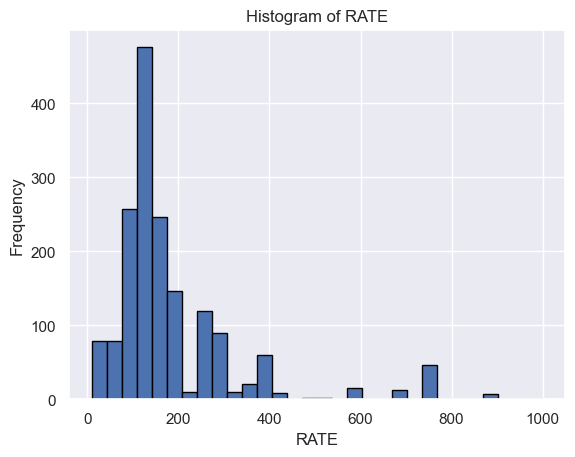

((array([-3.34574786, -3.09144144, -2.95019352, ...,  2.95019352,
          3.09144144,  3.34574786]),
  array([  10.,   10.,   10., ...,  900.,  900., 1000.])),
 (128.44807803687263, 185.65719360568386, 0.8514817671330853))

Text(0.5, 1.0, 'Q-Q plot of RATE')

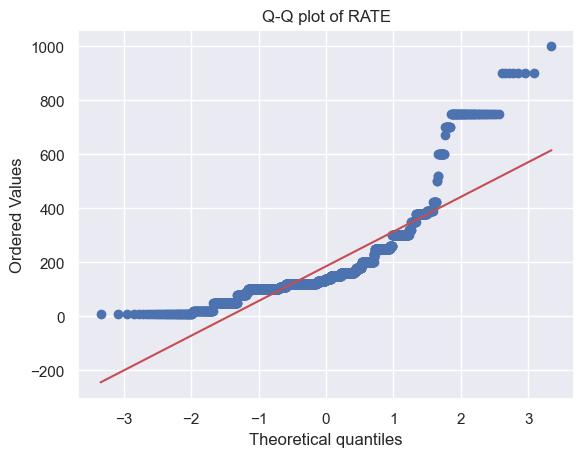

Shapiro-Wilk test:
W: 0.7252808809280396, p-value: 0.0
Anderson-Darling test:
Statistic: 139.16692731944386


Data does not look normal (reject H0)
Performing z-score of 3 to remove outliers... 




,POD,RATE
0,2005-10-03,390.0
1,2005-10-03,390.0
2,2005-10-07,390.0
3,2005-10-07,390.0
4,2005-10-14,390.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1623 entries, 0 to 1622
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     1623 non-null   datetime64[ns]
 1   RATE    1623 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 25.5 KB


In [45]:
# Histogram
plt.hist(sel_feat_df['RATE'], bins=30, edgecolor='black')
plt.title("Histogram of RATE")
plt.xlabel("RATE")
plt.ylabel("Frequency")
plt.show()

# Q-Q plot
stats.probplot(sel_feat_df['RATE'], plot=plt)
plt.title("Q-Q plot of RATE")
plt.show()

# Shapiro-Wilk test
print("Shapiro-Wilk test:")
W, p = stats.shapiro(sel_feat_df['RATE'])
print(f"W: {W}, p-value: {p}")

# Anderson-Darling test
print("Anderson-Darling test:")
result = stats.anderson(sel_feat_df['RATE'])
print(f"Statistic: {result.statistic}")
if result.statistic < result.critical_values[2]: # using a 5% significance level
    print("\n======================================")
    print("\nData looks normal (fail to reject H0)")
    print("Performing Interquartile Range (IQR) to remove outliers...")
    print("======================================\n")

    # IQR
    Q1 = sel_feat_df['RATE'].quantile(0.25)
    Q3 = sel_feat_df['RATE'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    sel_feat_df = sel_feat_df[(sel_feat_df['RATE'] >= lower_bound) & (sel_feat_df['RATE'] <= upper_bound)]

else:
    print("\n======================================")
    print("\nData does not look normal (reject H0)")
    print("Performing z-score of 3 to remove outliers... \n")
    print("======================================\n")

    # z-score
    z_scores = stats.zscore(sel_feat_df['RATE'])
    threshold = 3  # Z-score threshold for outlier detection

    # Remove outliers
    robust_df = sel_feat_df[(np.abs(z_scores) < threshold)]

# Reset the index
robust_df.reset_index(drop=True, inplace=True)

# Print the modified DataFrame
robust_df.head()
robust_df.info()

<h4>Interpolate missing values in between dates</h4>

In [46]:
# Remove duplicated dates and cost rows
robust_df = robust_df.drop_duplicates(subset=['POD', 'RATE']).reset_index(drop=True)

# Create a new dataframe with a date range from min to max date in your dataframe
new_df = pd.DataFrame()
new_df['POD'] = pd.date_range(start=robust_df['POD'].min(), end=robust_df['POD'].max())

# Merge the original dataframe with the new one. Missing dates in the original dataframe will be filled with NaN
df_interpolated = pd.merge(new_df, robust_df, on='POD', how='left')  

# Perform interpolation polynomial
df_interpolated['RATE'] = df_interpolated['RATE'].interpolate(method='polynomial', order=1)

df_interpolated['RATE'] = df_interpolated['RATE'].round(3)

df_interpolated.head(5)
df_interpolated.tail(5)
df_interpolated.info()

,POD,RATE
0,2005-10-03,390.0
1,2005-10-04,390.0
2,2005-10-05,390.0
3,2005-10-06,390.0
4,2005-10-07,390.0


,POD,RATE
6366,2023-02-24,300.0
6367,2023-02-25,300.0
6368,2023-02-26,300.0
6369,2023-02-27,300.0
6370,2023-02-28,300.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6371 entries, 0 to 6370
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   POD     6371 non-null   datetime64[ns]
 1   RATE    6371 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 149.3 KB


<h4>Grouping it to week</h4>

In [47]:
# Create YearMonthWeek directly from the 'POD'
df_interpolated['YearMonthWeek'] = df_interpolated['POD'] - pd.to_timedelta(df_interpolated['POD'].dt.dayofweek, unit='D')

# Create a new dataframe with every week in the range
all_weeks = pd.date_range(start=df_interpolated['POD'].min(), end=df_interpolated['POD'].max(), freq='W')
all_weeks_df = pd.DataFrame(all_weeks, columns=['POD'])

# Create YearMonthWeek in all_weeks_df
all_weeks_df['YearMonthWeek'] = all_weeks_df['POD'] - pd.to_timedelta(all_weeks_df['POD'].dt.dayofweek, unit='D')

# Merge this with your original dataframe
merged_df = pd.merge(all_weeks_df, df_interpolated, on=['YearMonthWeek'], how='left')

# Now you can group by YearMonthWeek and compute your rate
grouped = merged_df.groupby(['YearMonthWeek'])

agg_df = pd.DataFrame(columns=['YearMonthWeek', 'Rate'])

for group_name, group_df in grouped:
    year_month_week = group_name

    # Skip if no data for this week
    if group_df['RATE'].isnull().all():
        continue

    # Calculate sum and skewness of RATE values
    rate_sum = group_df['RATE'].sum()
    rate_skew = group_df['RATE'].skew()

    # Calculate trimmed mean of RATE values
    # rate_metric = stats.trim_mean(group_df['RATE'].dropna().values, 0.1) # trimming 10% from each end
    if abs(rate_skew) > 0.5:
        rate_metric = group_df['RATE'].median()
    else:
        rate_metric = group_df['RATE'].mean()

    new_row = {
        'YearMonthWeek': year_month_week,
        'Rate': rate_metric
    }

    # Append row to aggregated dataframe
    agg_df = agg_df.append(new_row, ignore_index=True)

agg_df = agg_df.sort_values(by='YearMonthWeek').reset_index(drop=True)
agg_df['Rate'] = agg_df['Rate'].round(2)

agg_df.head(15)
agg_df.tail(15)
agg_df.info()


C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_34200\3163205356.py:19: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group_name, group_df in grouped:
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_34200\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_34200\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  agg_df = agg_df.append(new_row, ignore_index=True)
C:\Users\Aloysius Wong\AppData\Local\Temp\ipykernel_34200\3163205356.py:43: FutureWarning: The frame.append method is deprecated and will be r

,YearMonthWeek,Rate
0,2005-10-03,390.0
1,2005-10-10,390.0
2,2005-10-17,390.0
3,2005-10-24,390.0
4,2005-10-31,390.0
5,2005-11-07,390.0
6,2005-11-14,390.0
7,2005-11-21,390.0
8,2005-11-28,390.0
9,2005-12-05,390.0


,YearMonthWeek,Rate
893,2022-11-14,150.00
894,2022-11-21,150.00
895,2022-11-28,191.43
896,2022-12-05,150.00
897,2022-12-12,211.54
898,2022-12-19,157.69
899,2022-12-26,150.00
900,2023-01-02,278.57
901,2023-01-09,300.00
902,2023-01-16,300.00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   YearMonthWeek  908 non-null    datetime64[ns]
 1   Rate           908 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.3 KB


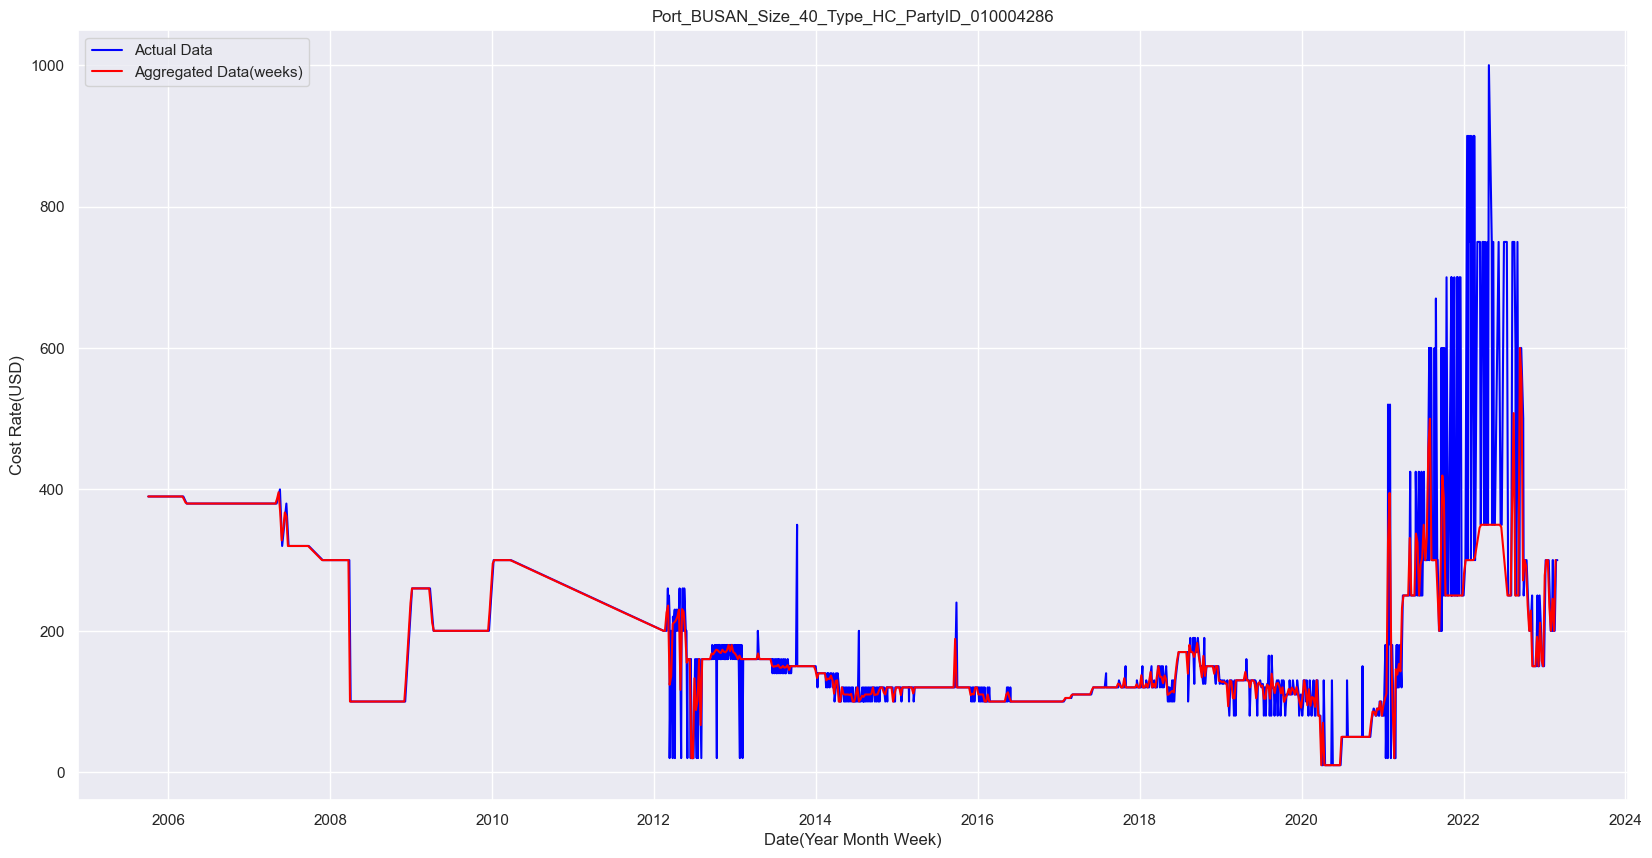

In [48]:
plt.figure(figsize=(20, 10))
plt.plot(sel_df['POD'], sel_df['RATE'], color='blue', label="Actual Data")
plt.plot(agg_df['YearMonthWeek'], agg_df['Rate'], color='red', label="Aggregated Data(weeks)")

plt.xlabel('Date(Year Month Week)')
plt.ylabel('Cost Rate(USD)')
plt.title(sel_country)
plt.legend()
plt.show();

<h4>Latest datapoints from Latest dataframe for comparing after forecasting (Measure accuracy)</h4>

In [49]:
max_date_in_old = sel_df['POD'].max()

# Create a new dataframe that only includes rows from the latest dataframe where the date is greater than the maximum date in the old dataframe
new_dates_df = latest_sel_df[latest_sel_df['POD'] > max_date_in_old].reset_index(drop=True)

# Print the new dataframe
new_dates_df.head(3)
new_dates_df.tail(3)
new_dates_df.info()

,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
0,ECS010230200077,010000419950,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
1,ECS010230200077,010000406570,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-08,40,HC,260.0
2,ECS010230200078,010000432251,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-03-15,40,HC,260.0


,CSL_ID,CNTR_ID,POD_ID,ETD_POL_D,PARTY_ID,PARTY_NAME,POD,CNTR_SIZE,CNTR_TYPE,RATE
20,ECS010230400203,010000544930,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-10,40,HC,300.0
21,ECS010230400183,010000565100,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0
22,ECS010230400183,010000554335,BUSAN,KRPUS,010004286,"GLOBELINK KOREA CO., LTD",2023-05-17,40,HC,260.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   CSL_ID      23 non-null     object        
 1   CNTR_ID     23 non-null     object        
 2   POD_ID      23 non-null     object        
 3   ETD_POL_D   23 non-null     object        
 4   PARTY_ID    23 non-null     object        
 5   PARTY_NAME  23 non-null     object        
 6   POD         23 non-null     datetime64[ns]
 7   CNTR_SIZE   23 non-null     object        
 8   CNTR_TYPE   23 non-null     object        
 9   RATE        23 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 1.9+ KB


<h4>LSTM Regression<h4>

In [50]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# Mean Square Error Function:
def calculate_RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Update create_dataset to handle multi-feature dataset
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers):
    model = Sequential()
    
    for i in range(len(lstm_layers)):
        if i == 0:
            # First layer specifies the input_shape and returns sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, input_shape=(look_back, trainX.shape[2]), 
                           activation='tanh', recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        elif i == len(lstm_layers) - 1:
            # Last layer doesn't return sequences
            model.add(LSTM(lstm_layers[i], activation='tanh', kernel_regularizer=l2(0.01)))
        else:
            # Middle layers return sequences
            model.add(LSTM(lstm_layers[i], return_sequences=True, activation='tanh', 
                           recurrent_activation='hard_sigmoid', kernel_regularizer=l2(0.01)))
        model.add(Dropout(0.2))
        
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0005))
    model.summary()

    # Add early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    
    # Fit the model and store the history
    history = model.fit(trainX, trainY, epochs=epochs, batch_size=128, verbose=2, 
                        validation_data=(testX, testY), callbacks=[es])
    return model, history


def plot_train_val_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model loss progress during training and validation')
    plt.xlabel('Epoch')
    plt.ylabel('Training and Validation Loss')
    plt.legend()
    plt.show()

Training for 50 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_138 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_138 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_139 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_139 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_140 (LSTM)             (None, 5, 32)             12416     
                                                                 
 dropout_140 (Dropout)       (None, 5, 32)             0         
                       

9/9 [==============================] - 0s 6ms/step
Train Score: 99.08 RMSE for 50 epochs
Test Score: 107.45 RMSE for 50 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_150 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_150 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_151 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_151 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_152 (LSTM)             (None, 5, 16)             3136      
                                                              

9/9 [==============================] - 0s 5ms/step
Train Score: 99.28 RMSE for 50 epochs
Test Score: 107.40 RMSE for 50 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_160 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_160 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_161 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_161 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_162 (LSTM)             (None, 5, 8)              800       
                                                                 
 dro

9/9 [==============================] - 0s 4ms/step
Train Score: 99.48 RMSE for 50 epochs
Test Score: 107.36 RMSE for 50 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_168 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_169 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_169 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_170 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_170

9/9 [==============================] - 0s 3ms/step
Train Score: 101.47 RMSE for 50 epochs
Test Score: 107.39 RMSE for 50 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_174 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_174 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_175 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_175 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_176 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_176 (Dro

9/9 [==============================] - 0s 2ms/step
Train Score: 99.55 RMSE for 50 epochs
Test Score: 107.80 RMSE for 50 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_178 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_178 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_179 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_179 (Dropout)       (None, 2)                 0         
                                                                 
 dense_24 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Trainab

9/9 [==============================] - 0s 1ms/step
Train Score: 95.03 RMSE for 50 epochs
Test Score: 100.54 RMSE for 50 epochs
Training for 100 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_180 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_180 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_181 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_181 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_182 (LSTM)             (None, 5, 32)             12416     
                           

9/9 [==============================] - 0s 6ms/step
Train Score: 98.40 RMSE for 100 epochs
Test Score: 107.73 RMSE for 100 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_192 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_192 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_193 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_193 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_194 (LSTM)             (None, 5, 16)             3136      
                                                            

9/9 [==============================] - 0s 5ms/step
Train Score: 98.95 RMSE for 100 epochs
Test Score: 107.49 RMSE for 100 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_202 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_202 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_203 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_203 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_204 (LSTM)             (None, 5, 8)              800       
                                                                 
 d

9/9 [==============================] - 0s 4ms/step
Train Score: 98.67 RMSE for 100 epochs
Test Score: 107.59 RMSE for 100 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_210 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_210 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_211 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_211 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_212 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_2

9/9 [==============================] - 0s 3ms/step
Train Score: 98.34 RMSE for 100 epochs
Test Score: 107.76 RMSE for 100 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_216 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_216 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_217 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_217 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_218 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_218 (Dr

9/9 [==============================] - 0s 2ms/step
Train Score: 98.15 RMSE for 100 epochs
Test Score: 107.40 RMSE for 100 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_220 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_220 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_221 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_221 (Dropout)       (None, 2)                 0         
                                                                 
 dense_30 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Train

9/9 [==============================] - 0s 2ms/step
Train Score: 102.92 RMSE for 100 epochs
Test Score: 112.26 RMSE for 100 epochs
Training for 150 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_222 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_222 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_223 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_223 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_224 (LSTM)             (None, 5, 32)             12416     
                        

9/9 [==============================] - 0s 6ms/step
Train Score: 98.01 RMSE for 150 epochs
Test Score: 108.01 RMSE for 150 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_234 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_234 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_235 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_235 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_236 (LSTM)             (None, 5, 16)             3136      
                                                            

9/9 [==============================] - 0s 5ms/step
Train Score: 97.82 RMSE for 150 epochs
Test Score: 108.20 RMSE for 150 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_244 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_244 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_245 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_245 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_246 (LSTM)             (None, 5, 8)              800       
                                                                 
 d

9/9 [==============================] - 0s 4ms/step
Train Score: 98.11 RMSE for 150 epochs
Test Score: 107.93 RMSE for 150 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_252 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_252 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_253 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_253 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_254 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_2

9/9 [==============================] - 0s 3ms/step
Train Score: 97.92 RMSE for 150 epochs
Test Score: 108.10 RMSE for 150 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_258 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_258 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_259 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_259 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_260 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_260 (Dr

9/9 [==============================] - 0s 2ms/step
Train Score: 98.03 RMSE for 150 epochs
Test Score: 107.99 RMSE for 150 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_262 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_262 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_263 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_263 (Dropout)       (None, 2)                 0         
                                                                 
 dense_36 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Train

9/9 [==============================] - 0s 2ms/step
Train Score: 69.61 RMSE for 150 epochs
Test Score: 82.39 RMSE for 150 epochs
Training for 300 epochs...
Training with LSTM layers: [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_264 (LSTM)             (None, 5, 64)             16896     
                                                                 
 dropout_264 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_265 (LSTM)             (None, 5, 64)             33024     
                                                                 
 dropout_265 (Dropout)       (None, 5, 64)             0         
                                                                 
 lstm_266 (LSTM)             (None, 5, 32)             12416     
                          

9/9 [==============================] - 0s 6ms/step
Train Score: 97.38 RMSE for 300 epochs
Test Score: 109.06 RMSE for 300 epochs
Training with LSTM layers: [32, 32, 16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_276 (LSTM)             (None, 5, 32)             4352      
                                                                 
 dropout_276 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_277 (LSTM)             (None, 5, 32)             8320      
                                                                 
 dropout_277 (Dropout)       (None, 5, 32)             0         
                                                                 
 lstm_278 (LSTM)             (None, 5, 16)             3136      
                                                            

9/9 [==============================] - 0s 5ms/step
Train Score: 97.43 RMSE for 300 epochs
Test Score: 108.89 RMSE for 300 epochs
Training with LSTM layers: [16, 16, 8, 8, 4, 4, 2, 2]
Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_286 (LSTM)             (None, 5, 16)             1152      
                                                                 
 dropout_286 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_287 (LSTM)             (None, 5, 16)             2112      
                                                                 
 dropout_287 (Dropout)       (None, 5, 16)             0         
                                                                 
 lstm_288 (LSTM)             (None, 5, 8)              800       
                                                                 
 d

9/9 [==============================] - 0s 4ms/step
Train Score: 97.42 RMSE for 300 epochs
Test Score: 108.92 RMSE for 300 epochs
Training with LSTM layers: [8, 8, 4, 4, 2, 2]
Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_294 (LSTM)             (None, 5, 8)              320       
                                                                 
 dropout_294 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_295 (LSTM)             (None, 5, 8)              544       
                                                                 
 dropout_295 (Dropout)       (None, 5, 8)              0         
                                                                 
 lstm_296 (LSTM)             (None, 5, 4)              208       
                                                                 
 dropout_2

9/9 [==============================] - 0s 3ms/step
Train Score: 97.43 RMSE for 300 epochs
Test Score: 108.88 RMSE for 300 epochs
Training with LSTM layers: [4, 4, 2, 2]
Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_300 (LSTM)             (None, 5, 4)              96        
                                                                 
 dropout_300 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_301 (LSTM)             (None, 5, 4)              144       
                                                                 
 dropout_301 (Dropout)       (None, 5, 4)              0         
                                                                 
 lstm_302 (LSTM)             (None, 5, 2)              56        
                                                                 
 dropout_302 (Dr

9/9 [==============================] - 0s 3ms/step
Train Score: 97.47 RMSE for 300 epochs
Test Score: 108.78 RMSE for 300 epochs
Training with LSTM layers: [2, 2]
Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_304 (LSTM)             (None, 5, 2)              32        
                                                                 
 dropout_304 (Dropout)       (None, 5, 2)              0         
                                                                 
 lstm_305 (LSTM)             (None, 2)                 40        
                                                                 
 dropout_305 (Dropout)       (None, 2)                 0         
                                                                 
 dense_42 (Dense)            (None, 1)                 3         
                                                                 
Total params: 75
Train

9/9 [==============================] - 0s 2ms/step
Train Score: 32.85 RMSE for 300 epochs
Test Score: 59.89 RMSE for 300 epochs


<Figure size 1000x800 with 0 Axes>

Text(0.5, 1.0, 'Model loss progress during training and validation')

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Training and Validation Loss')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


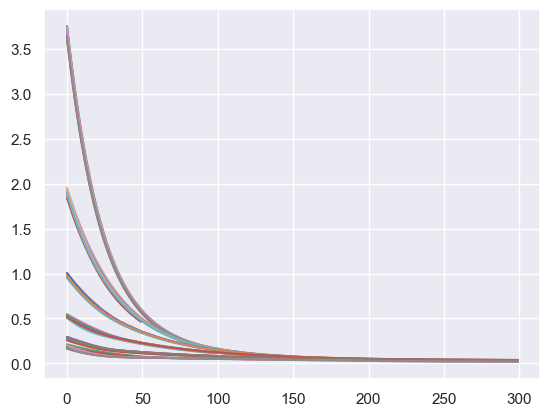

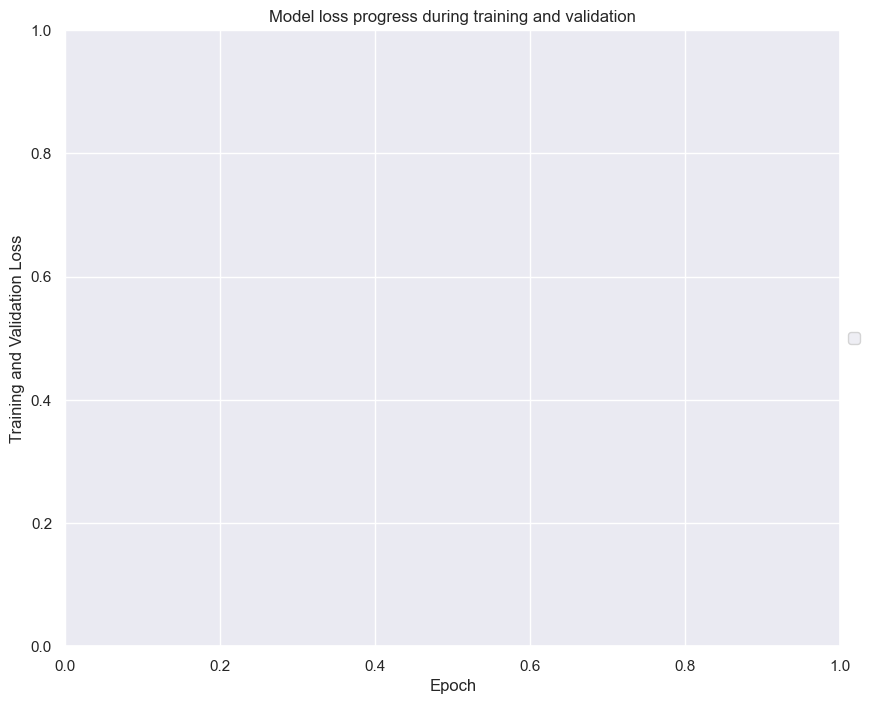

                                                    Train RMSE   Test RMSE
50 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4,...   99.083638  107.447547
50 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] l...   99.281754  107.400563
50 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers         99.484213  107.364215
50 epochs, [8, 8, 4, 4, 2, 2] layers                101.470481  107.386640
50 epochs, [4, 4, 2, 2] layers                       99.553599  107.804640
50 epochs, [2, 2] layers                             95.033737  100.536374
100 epochs, [64, 64, 32, 32, 16, 16, 8, 8, 4, 4...   98.398297  107.725139
100 epochs, [32, 32, 16, 16, 8, 8, 4, 4, 2, 2] ...   98.950592  107.486124
100 epochs, [16, 16, 8, 8, 4, 4, 2, 2] layers        98.674416  107.587586
100 epochs, [8, 8, 4, 4, 2, 2] layers                98.343720  107.759653
100 epochs, [4, 4, 2, 2] layers                      98.149481  107.403703
100 epochs, [2, 2] layers                           102.917628  112.260233
150 epochs, [64, 64, 32, 

In [51]:
# Initialize two separate scalers for normalization
scaler_rate = MinMaxScaler(feature_range=(0, 1))

# Fit and transform 'RATE' and 'during_covid' separately
rate_scaled = scaler_rate.fit_transform(agg_df[['Rate']])

# Concatenate the scaled data
dataset = np.concatenate([rate_scaled], axis=1)

# Split into train and test sets
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Reshape into X=t and Y=t+1, timestep  look_back
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], look_back, trainX.shape[2]))
testX = np.reshape(testX, (testX.shape[0], look_back, testX.shape[2]))

epochs_list = [50, 100, 150, 300]

lstm_layers_list = [
    [64, 64, 32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [32, 32, 16, 16, 8, 8, 4, 4, 2, 2],
    [16, 16, 8, 8, 4, 4, 2, 2],
    [8, 8, 4, 4, 2, 2],
    [4, 4, 2, 2],
    [2, 2]
]

rmse_results = {}

for epochs in epochs_list:
    print(f'Training for {epochs} epochs...')
    
    for lstm_layers in lstm_layers_list:
        print(f'Training with LSTM layers: {lstm_layers}')
        model, history = create_LSTM_model(trainX, trainY, testX, testY, epochs, lstm_layers)
        
        # Add the loss for this model to the plot
        plt.plot(history.history['loss'], label=f'Train Loss - {epochs} epochs, layers: {lstm_layers}')
        plt.plot(history.history['val_loss'], label=f'Validation Loss - {epochs} epochs, layers: {lstm_layers}')

        # Evalute LSTM Model
        trainPredict = model.predict(trainX)
        testPredict = model.predict(testX)

        # inverse_transform
        trainPredict = scaler_rate.inverse_transform(trainPredict)
        trainY_orig = scaler_rate.inverse_transform([trainY])
        testPredict = scaler_rate.inverse_transform(testPredict)
        testY_orig = scaler_rate.inverse_transform([testY])

        # Calculate mean squared error
        trainScore = calculate_RMSE(trainY_orig[0], trainPredict[:,0])
        print(f'Train Score: {trainScore:.2f} RMSE for {epochs} epochs')
        testScore = calculate_RMSE(testY_orig[0], testPredict[:,0])
        print(f'Test Score: {testScore:.2f} RMSE for {epochs} epochs')

        rmse_results[f'{epochs} epochs, {lstm_layers} layers'] = {'Train RMSE': trainScore, 'Test RMSE': testScore}

# Configure and show the plot
plt.figure(figsize=(10,8))
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Training and Validation Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show();

# Convert the dictionary to a DataFrame for easy display
rmse_df = pd.DataFrame(rmse_results).T
print(rmse_df)